## 1. 예측 모델에 대한 개발 설명 

### A. 분석 배경 및 과정
저희의 모델은 기본적으로 __LightGBM__ 을 이용하여 __Regression__과 __Classification__을 동시에 진행하였습니다. hold_d 예측값을 회귀로 산출을 해준 다음, 분류에 따라 장기투자자라고 예측이 될수록 가중치를 부여하는 방식으로 진행했습니다.

- __첫 번째 문제점: test_data와 train_data의 분포 상이__


저희 팀은 모델을 학습시키기에 앞서 __test_data의 분포가 train_data의 분포와는 다소 다를 것__이라는 가설을 세웠습니다. train_data의 경우 주식을 매도한 시점이 다양하지만, test_data의 경우 2020년까지 홀딩하고 있다가 2021년에 매도를 한 고객들의 hold 값이 모여 있습니다. 그렇기에 train data보다 test data 내의 hold_d의 값이 평균적으로 클 것이라고 예측을 하였습니다.
<br/>

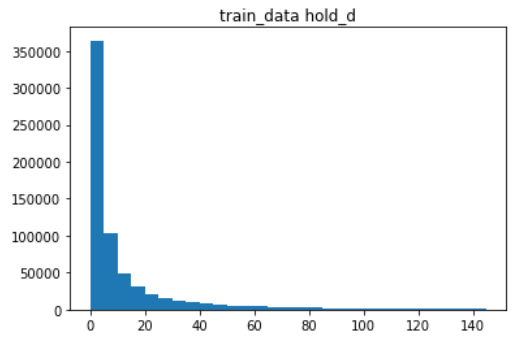
> train data의 hold_d 분포


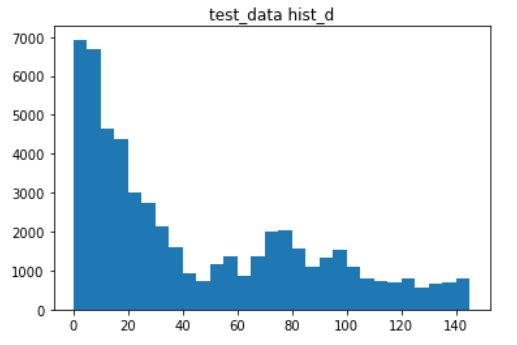
> test data의 hist_d 분포


train_data의 hist_d가 주어지지 않아 hist_d의 분포와 가장 유사할 수 있는 hold_d의 분포를 확인하였습니다. 그 결과 위와 같이 개인투자자들은 단기투자가 많지만, test_data의 경우 train data보다 더 넓게 hist_d 데이터 값이 분포하고 있음을 알 수 있습니다. 이는 기존 가설과 같이  train_data의 분포와 test_data의 분포가 어느 정도 다르다는 것을 의미합니다. 따라서 __train_data를 그대로 학습시킨 뒤 test_data로 예측을 할 경우, 예측이 잘 안 될 것이라고 판단했습니다.__ 저희는 위와 같이 train_data와 test_data의 분포가 다르다는 것을 고려하여 여러 조치를 취하였습니다. 해당 조치는 train_data의 hist_d를 생성한 원리를 설명한 뒤에 자세히 설명하겠습니다.
<br/>
<br/>
- __두번째 문제점: train_data의 hist_d 컬럼 부재__

다른 문제점은 __train_data의 hist_d의 부재__입니다. 

test_data의 경우 hist_d의 마지막 시점이 전부 2020년 12월 31일로 고정이 되어 있지만, train_data의 경우는 2016년에서 2020년 사이에 매도한 데이터이므로 매도 시점을 특정한 시점으로 고정하기 어렵습니다. 만약 비슷한 시점으로 2019년 12월 31일까지를 hist_d로 시점을 고정하고, 20년에 매도한 데이터를 관찰할 경우 train_data의 수가 급격히 적어져 오히려 Underfitting의 문제가 발생할 가능성이 컸습니다.
<br/>
<br/>
따라서 저희는 __시점을 고정하지 않고 hold 값과 0 사이의 random값을 추출하여 hist_d로 부여__하였습니다. 이는 시점이 고정되어 있지 않아 보다 폭넓은 Dataset 에 활용을 할 수 있으며, hist_d의 특성(이전에도 오래 주식을 보유했던 사람이 앞으로도 오래 들고 있을 가능성이 크다는 것)을 잘 표현해준다고 판단하였습니다.

hist_d 값이 약간 변동할 수 있지만, 많은 양의 데이터를 확보했기 때문에 RMSE는 더욱 낮았습니다.

> hist_d를 랜덤하게 설정해준 결과
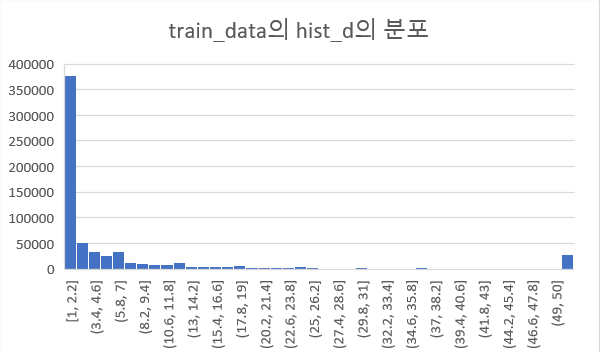

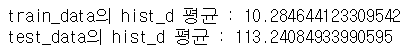



위의 값에서 알 수 있듯이, __train_data의 평균 hist_d__는 __10 에서 20 사이__입니다. 이는 hist_d가 random값임에도 어느 정도 평균이 유지가 되었습니다. 반면에 __test_data에서의 평균 hist_d__값은 상대적으로 높은 __113.24__가 나왔습니다. 이러한 분석결과를 바탕으로 train_data보다 test_data의 평균 hold_d가 훨씬 높게 나올 것이라고 예상했습니다.


이를 예방하기 위해 train_data의 hist_d값을 평균적으로 113 근처로 조정하여 hold_d값이 얼마나 변화하는지를 관찰하였습니다.
<br/>
<br/>
> * train_data의 hist_d를 110~113으로 조정했을 때 hold_d


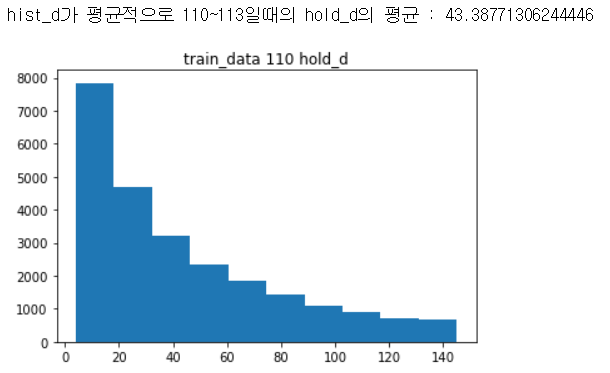

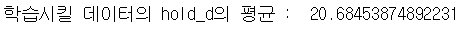


test_data의 hist_d 평균이 113 정도일 때 hold_d 평균값(이하 high_avg)은 43 정도로 나오는 것을 알 수 있습니다. 이는 학습시키려는 train_data의 평균적인 hold_d값(이하 avg1)과 차이가 있음을 알 수 있습니다. 학습시킬 train_data의 평균적인 hold_d값은 21 정도가 나오며 이는 평균적으로 20일만큼 큽니다.

비록 정확한 test_data의 분포를 구하지는 못했지만, 어느 정도 test_data의 평균이 편향되어 있음을 유추할 수 있습니다.

따라서 저희 팀은 train_data를 학습시킨 모델에 test_data를 적용할 때에 `high_avg -avg1`(약 20 ~ 25 사잇값) 만큼의 값을 예측값에 전체적으로 더해주기로 하였습니다.

따라서 저희의 test_data에 적용할 최종모델은 다음과 같습니다. 

classification으로 투자기간 유형을 예측하여 장기투자자일수록 hold_d 예측값에 가중치를 주었습니다.

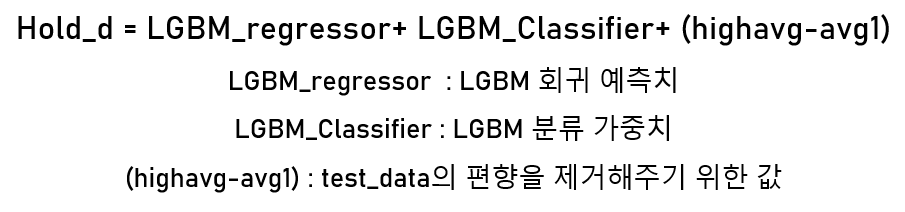

### A'. 채택된 변수에 대한 설명

- 사용 변수 리스트
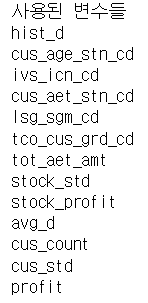

__1) 대회 내부 데이터 채택 변수__

변수(Feature)는 우선 데이콘 내에서 제공하는 카테고리형 변수들은 제거해주었습니다. 카테고리형 변수에 One-Hot Encoding을 적용한 경우 차원의 수가 대폭으로 늘어 오히려 학습의 결과가 좋지 못했습니다. 따라서 다음과 같은 대부분의 카테고리형 변수는 제거해주었고, 숫자의 크기로 대소구분이 가능한 순서형 변수는 유지했습니다.

`
cus_aet_stn_cd(고객 자산구간), cus_age_stn_cd(연령구간), lsg_sgm_cd(LIFE STAGE), tco_cus_grd_cd(고객등급), ivs_icn_cd(투자성향), tot_ivs_te_sgm_cd(총 투자기간), stk_dit_cd(시장구분)
`

또한, 대회에서 제공해주는 `tot_aet_amt(잔고금액)` 변수는 투자금액이 클수록 더 오래 보유하고 있는 투자자의 심리를 반영하기 위해 채택했습니다. 실제 모델 내에서도 영향력 있는 변수로 꼽혔습니다. 
<br/>
<br/>
__2) 외부 데이터 채택 변수__

저희는 또한 대회 내의 카테고리 변수만으로는 보유일을 예측하는 데 한계가 있다고 판단하여, 변수 자체를 외부에서 가져와 보았습니다.

고객이 매수한 주식의 16년부터 20년까지의 __평균 주간수익률__과 __평균 주간변동성__을 구하여 CSV 파일로 저장을 하였습니다. (`NH_std_list.csv` / 세부 사항은 2. 외부데이터 설명에 설명하겠습니다.)

평균 주간변동성이 큰 주식일수록 투자자가 손실을 볼 가능성이 클 것이라고 판단하여 채택하였습니다. 평균 주간수익률 역시 평균적으로 하락을 맞은 종목들을 매수한 고객들이 더욱 오래 들고 있을 경향을 반영하기 위함입니다. 이러한 가설로 영향력이 기존 train_data의 변수들보다 예측력이 높을 것으로 판단하였습니다.

다만, 이 데이터의 단점은 train_data의 보유 시점은 각기 다양하지만 16년부터 20년까지로 주식 평균 수익률이 고정되어 있다는 점입니다. 이러한 점 때문에 따로 고객 개인별 수익률(profit)을 추가하였습니다. 주가 데이터를 블룸버그 터미널 내에서 데이터를 받아왔으며, 생각보다 액면분할, 증자, 감자 등의 이슈 때문에 수익률이 정확히 산정되지 않는다는 단점이 있었습니다.
(`price_data_1.csv` / 세부 사항은 2. 외부데이터 설명에 설명하겠습니다.)

이외에도 데이터 이전에 보유 이력이 있는 데이터들은 보유일을 평균 내주어 `avg_d`라는 변수를 만들고 보유일의 과거 보유일의 표준편차(`avg_std`) 역시 구해보았습니다. 이 변수들은 과거 hold_d를 기반으로 한 변수이며, 영향력이 높으리라 판단하였습니다.


저희는 이렇게 데이콘 내부의 데이터와 외부의 데이터를 이용하여 모델을 학습시키기로 하였습니다. 하지만, 학습하는 과정에서 변수들의 차원이 많아져 이 차원을 축소하기로 하였습니다. 따라서, 변수들의 특성에 따라 PCA를 진행하여 학습시켜보았습니다.



__3) 파생변수(PCA 적용)__


고객과 주식 데이터를 PCA로 차원축소를 진행하였습니다. 고객의 과거 평균 보유일의 편차 및 거래 횟수, 거래하는 주식의 5년간 주간 수익률 평균, 5년간 주간 수익률 표준편차 이 4개의 데이터를 PCA로 차원 축소하였습니다. avg_d는 상대적으로 모델을 실행하여 중요도가 높게 나와 PCA 과정에서 제외하였습니다.

변수명은 (`principal component1`,`principal component2`)로 지정을 해주었습니다.

또한 숫자의 크기가 나름 유의미한 값을 지닌다고 판단한 데이터들을 묶어서 PCA를 진행해주었습니다.
(ex. 나이는 나이가 많을수록 숫자가 커지며, 자산구간이 커질수록 숫자가 커지게끔 인코딩이 되어있습니다.)
변수는 `cus_aet_stn_cd` ,`cus_age_stn_cd`,`lsg_sgm_cd`,`tco_cus_grd_cd`,`ivs_icn_cd`,`tot_ivs_te_sgm_cd`를 사용하였습니다.

변수명은 (`principal component3`)로 지정을 해주었습니다.


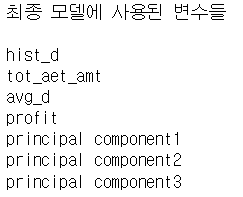

### B. 분석의 범주

위에서 볼 수 있었듯이 train_data는 test_data와 분포가 많이 다르기 때문에, test_data의 특성에 맞추어 극단적으로 작은 hold_d값은 제거해주었습니다. 또한 test_data의 hold_d값이 최대 146일까지 밖에 존재하지 않기에 train_data의 hold_d값을 3에서 146 사이로 제한을 걸어주었습니다.


### C. 모델링 진행 및 중요한 가정들

위에서 언급하였듯이 데이터 분포의 한계점을 인지하여 test_data의 결괏값에 전체적으로 `(high_avg - avg_1)`을 더해주었습니다.
이는 test_data의 분포와 비슷하게 train_data의 분포를 맞춰주었을 때 train_data의 개수가 현저히 적어져 Underfitting 되는 점의 한계를 인지한 점으로부터 기인하였습니다.

모델은 최종적으로 LightGBM 모델을 선정하였으며, 이는 빠른 속도와 leaf-wise 모델원리로 XGBoost보다 loss가 줄어듦을 확인하였습니다.

밑의 사진의 출처는 다음과 같습니다.

출처 : https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

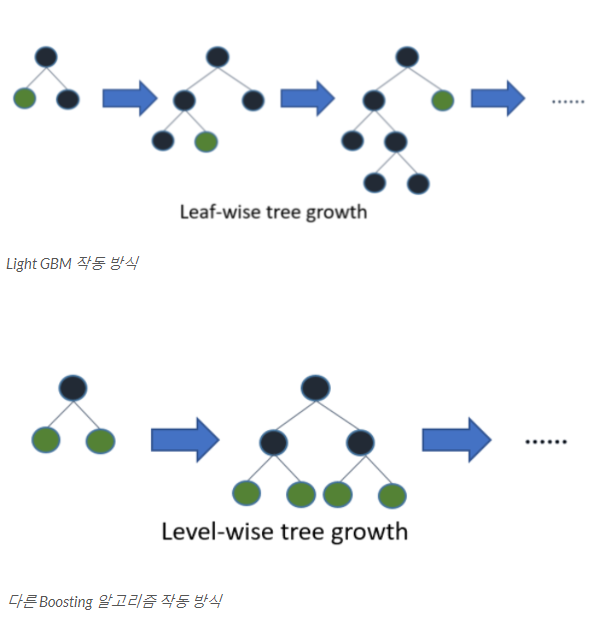

### D. 모델학습 과정

회귀분석과 분류를 동시에 진행하기 위해 두 개의 학습용 데이터(train_data, train_data_cla)를 이용하여 학습을 진행하였습니다.
분류의 경우 y_data값이 0, 1, 2, 3 ... 으로 인코딩이 되어야 하기 때문입니다. 

인코딩하는 과정은 다음과 같이 임의로 범위를 정하여 인코딩해주었습니다. (10 / 40 / 100)

지나치게 가중치를 더해주는 것을 막기 위해 분류가 최대한 낮게 되게끔 분류 경계치를 낮게 설정하였습니다. 장기투자자를 중기 투자자로 분류하여 가중치를 조금만 더해주는 것이 단기투자자를 장기투자자로 분류하여 가중치를 지나치게 더해주는 것보다 모델의 오류를 작게할 수 있기 때문입니다. 따라서 모델 결괏값을 정확도가 아닌 F1 score로 성능을 측정하도록 계획하였습니다.
인코딩 방식은 다음과 같습니다.


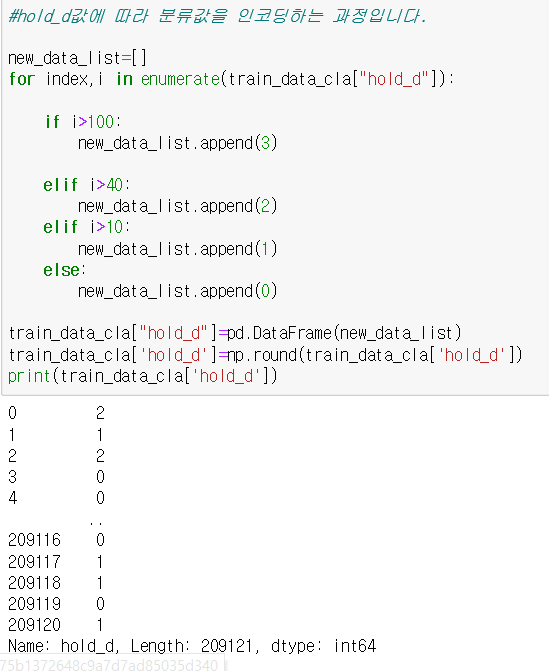

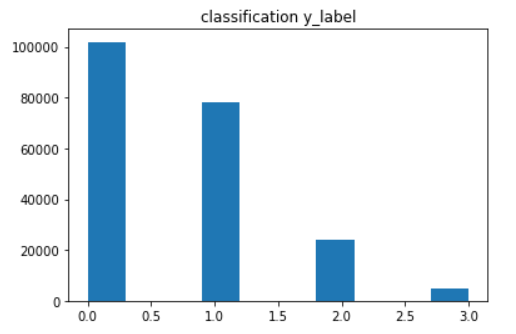

이외에도 train_data를 랜덤으로 10% 정도 split한 뒤 validation_data로 선정한 뒤 early_stopping을 해주었습니다. 

### E. 모델학습 결과값

결괏값은 0에서 146 사잇값으로 제한을 두었으며 범위 밖으로 값이 넘어가면 0 또는 146으로 값을 고정했습니다.

모델을 학습한 뒤 결괏값은 회귀식의 경우는 RMSE로 평가를 하였으며, 분류의 경우는 confusion_matrix를 통한 F1 score로 평가를 하였습니다.


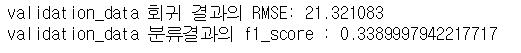

위의 성능치를 줄이도록 파라미터를 임의로 조정을 어느정도 해주었습니다.

또한 모델에 영향을 주는 변수들의 중요도를 확인해보았습니다.


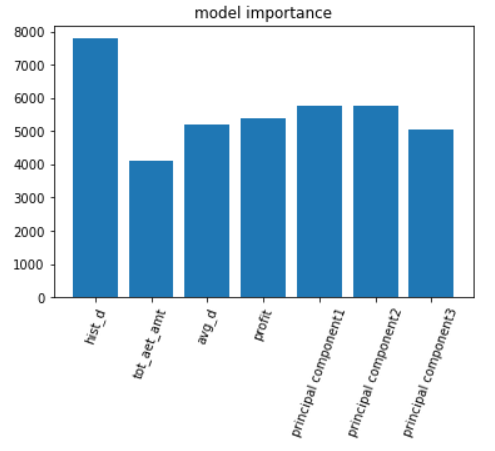

결과에서 알 수 있듯이 새로 추가한 변수들 중심으로 모델의 영향력이 높게 나왔으며, hist_d 와 avg_d가 높게 나오는 것을 확인할 수 있습니다.

이외에도 고객의 과거 보유일의 표준편차와 거래 횟수, 주식 데이터의 5년 치 평균 및 표준편차를 PCA 적용한 component 1, 2 값이 영향력이 높게 나왔습니다.

## 2. 외부 데이터에 대한 설명

외부에서 데이터 전처리한 결과들은 전부 GitHub에 저장하였습니다. 밑의 사이트에 들어가셔서 세부 데이터의 값들을 보실 수 있습니다.
전 종목의 주가 데이터 경우에는 데이터 용량이 너무 커서 GitHub에 업로드하는데 한계가 있었습니다. 그래서 두 부분으로 쪼개서 파일을 업로드 하였습니다.

GitHub 주소 : https://github.com/wonsikd/NH_code/tree/main

가장 먼저 설명해 드릴 외부 데이터는 키움 API를 활용한 5년 치 주간 수익률 및 변동성입니다.


NH 투자증권에서 제공된 데이터 내에서는 주식 종목에 대한 특징을 잡아내기 어려운 단점이 있었습니다. 저희는 종목의 변동성이 평균적으로 크거나 종목의 수익률이 꾸준히 하락하는 종목일수록 개인투자자 입장에서 손실을 볼 수가 있었기에 오래 들고 있는 경향이 나타난다고 판단하였습니다.


따라서 다음과 같은 데이터를 API를 통해 수집하였습니다. Data Leakage를 방지하기 위해 20년 이전 주간 데이터만 불러왔습니다.

키움 API에 접속하는 코드입니다. File 명을 kiwoom으로 지정한 뒤 Main파일에서 불러와 실행시킵니다.
로그인 슬롯을 열어 로그인하는 것이 이 파일 주요 목적입니다.
이후 Main파일에서 이 파일을 실행시켜 로그인한 뒤 데이터를 불러들입니다.
데이터를 불러들이는 code_db의 함수 기준일자를 20201231로 설정해두어 2020년 이전 주간 데이터만을 불러왔습니다.

In [1]:
'''
from PyQt5.QAxContainer import *
from PyQt5.QtCore import *
from config.errorCode import *
from PyQt5.QtTest import *
import pandas as pd
import datetime



class Kiwoom(QAxWidget):
    def __init__(self):
        super().__init__()

        ######## event loop 모음

        self.login_event_loop = None

        ##############
        ########스크린 번호 모음
        self.screen_calcuation_stock = "4000"

        ################
        ocx_instance()
        self.event_slots()
        self.signal_login_commConnect()


    def get_ocx_instance(self):
        self.setControl("KHOPENAPI.KHOpenAPICtrl.1")

    def event_slots(self):
        self.OnEventConnect.connect(self.login_slot)
        self.OnReceiveTrData.connect(self.trdata_slot)

    def signal_login_commConnect(self):
        self.dynamicCall("CommConnect()")

        self.login_event_loop = QEventLoop()
        self.login_event_loop.exec()

    def login_slot(self, errCode):
        print(errors(errCode))

        self.login_event_loop.exit()

    def code_db(self, code_list=None, sPrevNext_week="0"):

        QTest.qWait(3600)

        self.dynamicCall("SetInputValue(Qstring,Qstring)", "종목코드", code_list)
        self.dynamicCall("SetInputValue(Qstring, Qstring)", "기준일자", "20201231")
        self.dynamicCall("SetInputValue(Qstring, Qstring)", "끝일자", "20160101")
        self.dynamicCall("SetInputValue(Qstring, Qstring)", "수정주가구분", "1")
        self.dynamicCall("CommRqData(Qstring, Qstring, int, Qstring)", "주식주봉차트조회요청", "opt10082", sPrevNext_week,
                         self.screen_calcuation_stock)
        self.data = []
        self.caculator_eventloop = QEventLoop()
        self.caculator_eventloop.exec_()

        return self.data
    
    
    


    def trdata_slot(self, sScrNo, sRQName, sTrCode, sRecordName,sPrevNext):  
        # sPrevNext 다음 페이지가 있는지 알려주는거 2이면 더 있다.! #요청 받은 신호를 받고 출력하는 과정, 다음 함수 이용하는 과정은 KOA studio에 자세히 나와있습니다.
        # 원하는 요청값에 따라 elif 문으로 계속 추가를 하여 작성하는 원리입니다. 여러 데이터 중, tr데이터에 해당하는 값들만 해당합니다. 실시간 데이터나 다른 데이터 역시 받을 수 있으며, tr데이터 형태가 아니면 다른 슬롯을 열어줘야합니다.

        if sRQName == "주식일봉차트조회요청" or sRQName == "주식주봉차트조회요청":
            self.data = []  # 기존의 데이터 삭제하기 위해 추가하였다.

            code = self.dynamicCall("GetCommData(s,s,i,s)", sTrCode, sRQName, 0, "종목코드")
            code = code.strip()
            print("%s 요청중!" % code)
            rows = self.dynamicCall("GetRepeatCnt(s,s)", sTrCode, sRQName)
            print("해당종목의", rows, "데이터 개수를 조회하였습니다.")

            for i in range(rows):  # 주식 불러온 데이터를 정제하는 과정입니다. 문자형태일 경우를 제거하였습니다.
                data = []
                current_price = self.dynamicCall("GetCommData(s,s,i,s)", sTrCode, sRQName, i, "현재가")
                current_price = int(current_price.strip())
                volume = self.dynamicCall("GetCommData(s,s,i,s)", sTrCode, sRQName, i, "거래량")
                volume = int(volume.strip())
                date = self.dynamicCall("GetCommData(s,s,i,s)", sTrCode, sRQName, i, "일자")
                date = int(date.strip())
                start_price = self.dynamicCall("GetCommData(s,s,i,s)", sTrCode, sRQName, i, "시가")
                start_price = int(start_price.strip())
                low_price = self.dynamicCall("GetCommData(s,s,i,s)", sTrCode, sRQName, i, "저가")
                high_price = self.dynamicCall("GetCommData(s,s,i,s)", sTrCode, sRQName, i, "고가")
                low_price = int(low_price.strip())
                high_price = int(high_price.strip())
                data.append(date)
                data.append(current_price)
                data.append(start_price)
                data.append(low_price)
                data.append(high_price)
                data.append(volume)
                self.data.append(
                    data)  # self.data의 리스트 [[날짜1,종가,시가,저가,고가,거래량],[날짜2,종가,시가,저가,고가,거래량],...] 이렇게 리스트 속에 리스트로 이루어져있습니다.
                data = []  # 마지막 끝나고 data 안의 리스트를 제거해주기 위해 설정하였다.

            self.caculator_eventloop.exit()


'''

'\nfrom PyQt5.QAxContainer import *\nfrom PyQt5.QtCore import *\nfrom config.errorCode import *\nfrom PyQt5.QtTest import *\nimport pandas as pd\nimport datetime\n\n\n\nclass Kiwoom(QAxWidget):\n    def __init__(self):\n        super().__init__()\n\n        ######## event loop 모음\n\n        self.login_event_loop = None\n\n        ##############\n        ########스크린 번호 모음\n        self.screen_calcuation_stock = "4000"\n\n        ################\n        ocx_instance()\n        self.event_slots()\n        self.signal_login_commConnect()\n\n\n    def get_ocx_instance(self):\n        self.setControl("KHOPENAPI.KHOpenAPICtrl.1")\n\n    def event_slots(self):\n        self.OnEventConnect.connect(self.login_slot)\n        self.OnReceiveTrData.connect(self.trdata_slot)\n\n    def signal_login_commConnect(self):\n        self.dynamicCall("CommConnect()")\n\n        self.login_event_loop = QEventLoop()\n        self.login_event_loop.exec()\n\n    def login_slot(self, errCode):\n        print(er

데이터를 불러들이고 계산하는 Main 파일입니다. 이 파일의 목적은 종목정보에서 티커만 불러와 키움 API에 입력할 티커만 남깁니다.


Kiwoom.code_db로 데이터를 불러들이면 [[날짜1,종가,시가,저가,고가,거래량],[날짜2,종가,시가,저가,고가,거래량],...]으로 총 300주의 데이터를 가져옵니다. 기준일을 20201231로 지정해놨기 때문에 20201231 이전 300주의 데이터를 가져오지만 20160104까지의 데이터가 필요하므로 범위를 259(20160104)로 지정해두었습니다.


하지만, 20160104 이후에 상장한 종목들도 있었기 때문에 if 문을 걸어 일주일간 수익률의 평균과 20160104부터 20201231까지의 주간 변동성을 계산해주었습니다.
마지막으로 NH_std라는 파일로 저장하게끔 해주었습니다. (파일경로는 유의 부탁드립니다.)

In [2]:
'''
from Kiwoom import *
import datetime
import sys
from PyQt5.QtWidgets import *
import pandas as pd
import numpy as np

class Main():
    def __init__(self):
        self.app = QApplication(sys.argv)
        self.Kiwoom = Kiwoom()

        self.data = pd.read_csv('C:/Users/gjals/Desktop/open/iem_info_20210902.csv', usecols = ['iem_cd'])

        self.code = []
        for i in range(len(self.data)):
            self.code.append(self.data['iem_cd'][i][1:7])

        self.std_list = []
        for code in self.code:

            self.week_data = self.Kiwoom.code_db(code_list = code)

            self.tmpt_price = []
            self.tmpt_list = []
            self.tmpt_ret = []
            if len(self.week_data)-1 >= 259:
                for i in range(259):
                    self.tmpt_price.append(self.week_data[i][1])
                    self.tmpt_ret.append((self.week_data[i][1]-self.week_data[i+1][1])/self.week_data[i+1][1])
            else:
                for i in range(len(self.week_data)-1):
                    self.tmpt_price.append(self.week_data[i][1])
                for j in range(len(self.week_data)-2):
                    self.tmpt_ret.append((self.week_data[i][1]-self.week_data[i+1][1])/self.week_data[i+1][1])

            self.tmpt_list.append("A"+code)
            self.tmpt_list.append(np.std(self.tmpt_price)/np.mean(self.tmpt_price))
            self.tmpt_list.append(np.mean(self.tmpt_ret))
            self.std_list.append(self.tmpt_list)

        self.std_pd = pd.DataFrame(self.std_list)
        self.std_pd.columns = ['Ticker', '변동성', '평균 주간 수익률']

        filename = "NH_std_list"
        with pd.ExcelWriter('C:/Users/gjals/Desktop/{}.xlsx'.format(filename)) as writer:
            self.std_pd.to_excel(writer, sheet_name="result", index=False)

if __name__=="__main__":
    Main()
'''

'\nfrom Kiwoom import *\nimport datetime\nimport sys\nfrom PyQt5.QtWidgets import *\nimport pandas as pd\nimport numpy as np\n\nclass Main():\n    def __init__(self):\n        self.app = QApplication(sys.argv)\n        self.Kiwoom = Kiwoom()\n\n        self.data = pd.read_csv(\'C:/Users/gjals/Desktop/open/iem_info_20210902.csv\', usecols = [\'iem_cd\'])\n\n        self.code = []\n        for i in range(len(self.data)):\n            self.code.append(self.data[\'iem_cd\'][i][1:7])\n\n        self.std_list = []\n        for code in self.code:\n\n            self.week_data = self.Kiwoom.code_db(code_list = code)\n\n            self.tmpt_price = []\n            self.tmpt_list = []\n            self.tmpt_ret = []\n            if len(self.week_data)-1 >= 259:\n                for i in range(259):\n                    self.tmpt_price.append(self.week_data[i][1])\n                    self.tmpt_ret.append((self.week_data[i][1]-self.week_data[i+1][1])/self.week_data[i+1][1])\n            else:\n 

다음은 블룸버그 터미널을 이용해 전종목의 주가를 가져와보았습니다. 이를 통해서 각 고객들의 수익률을 평가하였습니다. 대회 내의 데이터를 이용해 매수단가를 계산할 수 있지만 수정주가가 반영 되어있지 않아서 매수일의 매수가도 가져와보았습니다.

BQUANT를 이용한 전 종목 종가 데이터를 불러오는 코드입니다. BQUANT에서 블룸버그 데이터를 가져오는bql 라이브러리를 가져온 후 종목정보에 있는 티커 정보를 블룸버그에서 사용할 수 있는 형태로 바꿔줍니다. 그 이후 한 종목 씩 20160104부터 20201231까지의 종가를 가져와 행으로 바꿔 기존 데이터프레임에 추가해주는 방식입니다.
데이터불러온 결과는 price_data.csv로 저장되게끔 하였으며, 이는 용량이 커서 두개의 파일로 나눠서 깃허브에 업로드를 하였습니다. 뿐만 아니라, 열에 해당하는 날짜는 계산의 편의성을 위해서 2020-12-30 과 같은 형식에서 20201230 과 같은 형식으로 바꿔주었습니다.

매수일부터 hist_d까지의 수익률을 구해서 그 수익이 낮거나 손해를 크게 볼수록 더욱 고객이 오래들고 있을 것이기에 더욱 높은 예측을 할 수 있을 것이라 기대합니다. 

In [3]:
'''
import bql
import pandas as pd
bq = bql.Service()

data = pd.read_csv('iem_info_20210902.csv')
corp_list = []
for i in data['iem_cd']:
    corp_list.append(i[1::]+' KS EQUITY')

date_range = bq.func.range('2016-01-04','2020-12-31')
last = bq.data.px_last(dates = date_range, fill = 'PREV', ca_adj = 'FULL')

data_pd = pd.DataFrame()
for i in range(len(corp_list)):
    
    request = bql.Request(corp_list[i], last)
    response = bq.execute(request)
    data = bql.combined_df(response)
    
    a = data.reset_index(drop = False).pivot_table(index='DATE')
    a = a.sort_index(ascending=True)
    a = a.rename(columns={'PX_LAST(fill=\'PREV\',dates=RANGE(2016-01-04,2020-12-31),ca_adj=\'FULL\')': 'A'+corp_list[i][0:6]})
    a = a.transpose()

    data_pd = pd.concat([data_pd, a], axis = 0)
    print(i)
    


data_pd.to_csv('price_data.csv', header = True, index = True)
'''

"\nimport bql\nimport pandas as pd\nbq = bql.Service()\n\ndata = pd.read_csv('iem_info_20210902.csv')\ncorp_list = []\nfor i in data['iem_cd']:\n    corp_list.append(i[1::]+' KS EQUITY')\n\ndate_range = bq.func.range('2016-01-04','2020-12-31')\nlast = bq.data.px_last(dates = date_range, fill = 'PREV', ca_adj = 'FULL')\n\ndata_pd = pd.DataFrame()\nfor i in range(len(corp_list)):\n    \n    request = bql.Request(corp_list[i], last)\n    response = bq.execute(request)\n    data = bql.combined_df(response)\n    \n    a = data.reset_index(drop = False).pivot_table(index='DATE')\n    a = a.sort_index(ascending=True)\n    a = a.rename(columns={'PX_LAST(fill='PREV',dates=RANGE(2016-01-04,2020-12-31),ca_adj='FULL')': 'A'+corp_list[i][0:6]})\n    a = a.transpose()\n\n    data_pd = pd.concat([data_pd, a], axis = 0)\n    print(i)\n    \n\n\ndata_pd.to_csv('price_data.csv', header = True, index = True)\n"